# Task 2 : 时间序列挖掘 + ABM构建学习

# 1 EDA：理解赛题数据

Exploratory Data Analysis，探索性数据分析

## 1.1 导包与前期准备

In [1]:
import pandas as pd
import seaborn as sns # matplotlib 的衍生库
import matplotlib.pylab as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore') # 设置警告过滤器，忽略所有警告信息
plt.style.use('ggplot') # plot 风格设置为ggplot
plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei',"SimHei"]
plt.rcParams['axes.unicode_minus'] = False  # 字体设置

base_path=Path("./data")

In [2]:
# 先读取 Task1 处理好的数据文件，其中要求 timestamp 按照日期格式解析，以第 0 列为索引
electricity_price = pd.read_csv(base_path/"electricity_price_parsed.csv", parse_dates=["timestamp"], index_col=0)
electricity_price.columns = ["demand", "price"]  # 原数据的列重命名
electricity_price.head()

,demand,price
timestamp,,
2021-12-01 00:15:00,40334.18,350.80
2021-12-01 00:30:00,40523.15,350.80
2021-12-01 00:45:00,40374.74,350.80
2021-12-01 01:00:00,40111.55,350.80
2021-12-01 01:15:00,40067.50,348.93


## 1.2 划分数据

- 训练集：数据集中price非空的数据
- 测试集：数据集中price为空的数据，也就是我们需要预测的数据

In [3]:
# bool 索引，price为空的为true
test_mask = electricity_price["price"].isna()

# 训练集索引，直接对测试集索引取反即可
train_mask = ~test_mask

# 看下划分结果
print(f"训练集范围：{electricity_price[train_mask].index.min()} --> {electricity_price[train_mask].index.max()}\t总长度{len(electricity_price[train_mask])}")
print(f"测试集范围：{electricity_price[test_mask].index.min()} --> {electricity_price[test_mask].index.max()}\t总长度{len(electricity_price[test_mask])}")

训练集范围：2021-12-01 00:15:00 --> 2023-07-01 00:00:00	总长度55392
测试集范围：2023-07-01 00:15:00 --> 2024-04-19 00:00:00	总长度28128


也就是说，我们要预测2023-07-01 00:15:00 --> 2024-04-19 00:00:00	的出清价格

## 1.3 数据可视化

简单观察数据，我们可以发现，虽然price是每隔15分钟形成的，但是它每小时才变化一次，我们可以看看是否符合：

In [4]:
electricity_price.head(12)

,demand,price
timestamp,,
2021-12-01 00:15:00,40334.18,350.80
2021-12-01 00:30:00,40523.15,350.80
2021-12-01 00:45:00,40374.74,350.80
2021-12-01 01:00:00,40111.55,350.80
2021-12-01 01:15:00,40067.50,348.93
2021-12-01 01:30:00,39562.02,348.93
2021-12-01 01:45:00,39629.90,348.93
2021-12-01 02:00:00,39121.31,348.93
2021-12-01 02:15:00,39124.08,347.01


可以看到，price每隔4项都是相同的，我们再写一个简单的循环验证下：

In [5]:
def check_repeated(data, repeat_count=4):
    # 步长： repeat_count=4
    # 这里需要注意，我们遍历的是 pd.DataFrame, 不是 python.array
    for i in range(0, len(data), repeat_count):
        # 从索引 i 开始，取长度为 repeat_count 的子序列
        subsequence = data[i:i + repeat_count]
        
        # 把取出来的子序列作为集合，如果集合基数不为1，直接break掉
        if len(set(subsequence)) != 1:
            print(f"不是重复{repeat_count} 次")
            return
    print(f"是重复{repeat_count} 次")
    
check_repeated(electricity_price[train_mask]["price"])

是重复4 次


接下来，我们来绘制一下2021-12-01的price走势，可视化数据：

In [6]:
data = electricity_price.loc['2021-12-01']
data

,demand,price
timestamp,,
2021-12-01 00:15:00,40334.18,350.80
2021-12-01 00:30:00,40523.15,350.80
2021-12-01 00:45:00,40374.74,350.80
2021-12-01 01:00:00,40111.55,350.80
2021-12-01 01:15:00,40067.50,348.93
...,...,...
2021-12-01 22:45:00,42515.16,352.78
2021-12-01 23:00:00,43192.68,352.78
2021-12-01 23:15:00,44785.87,361.44


<Figure size 960x720 with 0 Axes>

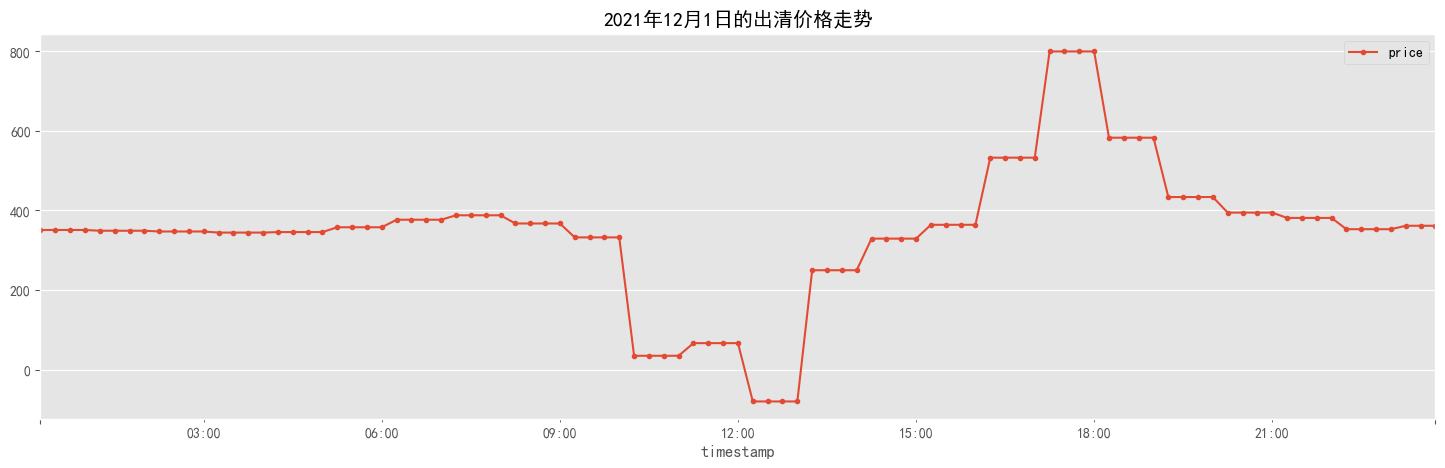

In [7]:
plt.figure(dpi=150) # 分辨率
data.plot(y="price",marker='o', markersize=3, figsize=(18, 5))
plt.title("2021年12月1日的出清价格走势")
plt.show()

从走势图标也可以看出是符合猜测的。

## 1.4 描述性统计

In [8]:
electricity_price.describe()

,demand,price
count,83520.000000,55392.000000
mean,36595.327516,360.002312
std,9588.519396,203.745125
min,6993.310000,-85.000000
25%,30214.722500,264.142500
50%,36704.025000,401.695000
75%,42868.577500,471.962500
max,75501.330000,1296.000000


只是表格，可能看的不是很清楚，我们来画下 demand 和 price 的分布图：

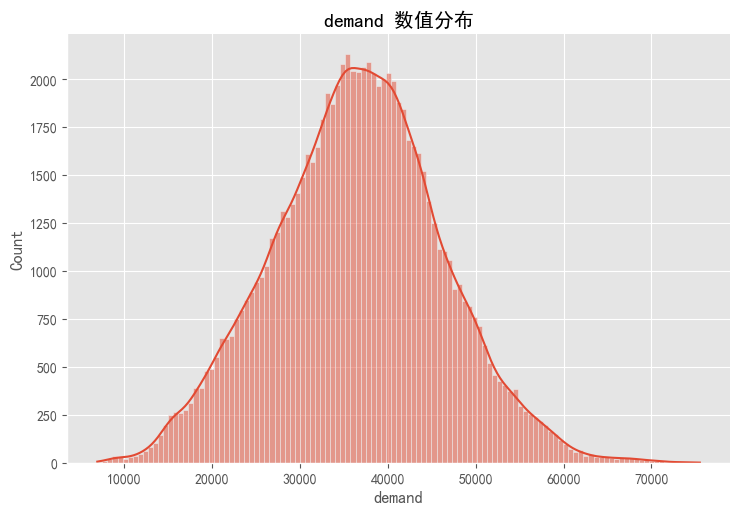

In [9]:
# 使用 Seaborn 库绘制 demand 的分布图
# sns.displot(...) 函数用于绘制数据的分布图
ax = sns.displot(
    electricity_price,  # 输入数据
    x="demand",         # 指定绘图的列，这里是 "demand" 列
    aspect=1.5,         # 图形的宽高比，1.5 表示宽度是高度的 1.5 倍
    height=5,           # 图形的高度设置为 5 英寸
    kde=True            # 启用核密度估计（KDE），用于绘制数据的平滑概率密度曲线
)

# 设置图形的标题
ax.set(title="demand 数值分布")

demand 数据比较好看，基本看起来符合正太分布

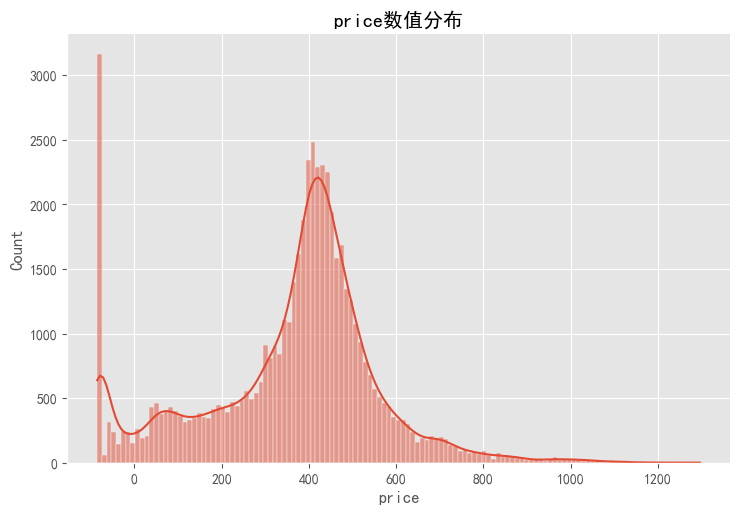

In [10]:
ax=sns.displot(
    electricity_price,
    x="price",
    aspect=1.5,
    height=5,
    kde=True)
ax.set(title="price数值分布")

可以发现，price的分布不是很好看，低价多，且头尾均有极端值分布。因此，我们需要再进一步分析price数据

## 1.5 分段数据统计分析

### 1.5.1 分小时统计

由于数据都是时间序列数据，我们需要考虑数据在时间上的特征。且经过我们刚刚分析，price每小时变动一次。

准备阶段：创建时、日、周、月、年的索引，方便后续分析

In [11]:
# 提取小时信息，并创建一个新列 "hour"
electricity_price["hour"] = electricity_price.index.hour
electricity_price["month"] = electricity_price.index.month
electricity_price["day"] = electricity_price.index.day
# 提取星期几的信息（0 = 周一, 6 = 周日），并创建一个新列 "weekday"
electricity_price["weekday"] = electricity_price.index.weekday
electricity_price["year"] = electricity_price.index.year

electricity_price.index, electricity_price

(DatetimeIndex(['2021-12-01 00:15:00', '2021-12-01 00:30:00',
                '2021-12-01 00:45:00', '2021-12-01 01:00:00',
                '2021-12-01 01:15:00', '2021-12-01 01:30:00',
                '2021-12-01 01:45:00', '2021-12-01 02:00:00',
                '2021-12-01 02:15:00', '2021-12-01 02:30:00',
                ...
                '2024-04-18 21:45:00', '2024-04-18 22:00:00',
                '2024-04-18 22:15:00', '2024-04-18 22:30:00',
                '2024-04-18 22:45:00', '2024-04-18 23:00:00',
                '2024-04-18 23:15:00', '2024-04-18 23:30:00',
                '2024-04-18 23:45:00', '2024-04-19 00:00:00'],
               dtype='datetime64[ns]', name='timestamp', length=83520, freq=None),
                        demand   price  hour  month  day  weekday  year
 timestamp                                                             
 2021-12-01 00:15:00  40334.18  350.80     0     12    1        2  2021
 2021-12-01 00:30:00  40523.15  350.80     0     12    1    

画出不同年份的分时走势图：

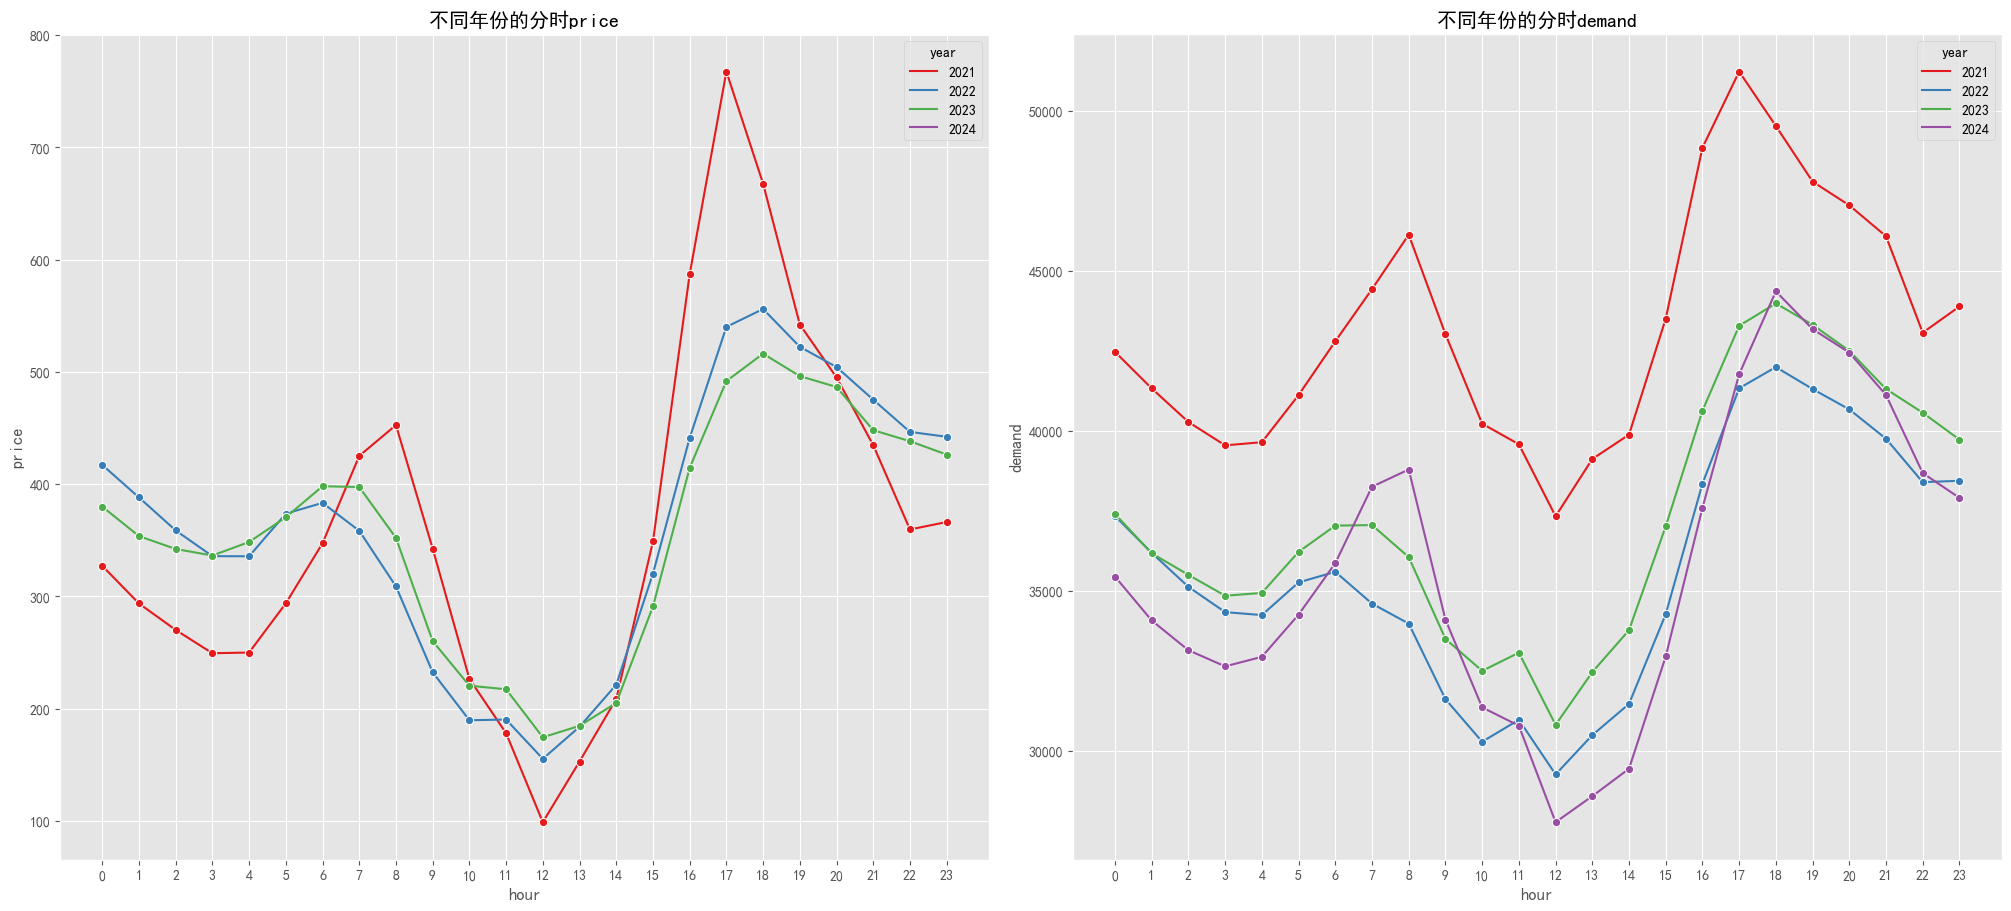

In [12]:
fig, ax = plt.subplots(      # subplot 图组
    1,                       # 子图的行数为 1
    2,                       # 子图的列数为 2
    figsize=(20, 9),         # 设置整个图形的大小为 20x9 英寸
    constrained_layout=True  # 启用约束布局以自动调整子图位置和大小
)

# 绘制不同年份的分时price折线图
sns.lineplot(
    electricity_price.groupby(["hour", "year"])["price"].mean().reset_index(),  # 按小时和年份分组，计算每组的平均电价，并重置索引
    x="hour",                  # x 轴数据为小时
    y="price",                 # y 轴数据为平均电价
    ax=ax[0],                  # 将图绘制到第一个子图 (ax[0])
    marker="o",                # 数据点标记为圆圈
    hue="year",                # 根据年份不同设置不同的颜色
    palette="Set1"             # 使用 "Set1" 调色板
)
ax[0].set_title("不同年份的分时price")  # 设置子图的标题
ax[0].set_xticks(range(24))         # 设置 x 轴刻度为 0 到 23（小时范围）

# 绘制不同年份的分时demand折线图
sns.lineplot(
    electricity_price.groupby(["hour", "year"])["demand"].mean().reset_index(),
    x="hour",            
    y="demand",                
    ax=ax[1],                  
    marker="o",              
    hue="year",           
    palette="Set1"
)
ax[1].set_title("不同年份的分时demand")  # 设置子图的标题
ax[1].set_xticks(range(24));         # 设置 x 轴刻度为 0 到 23（小时范围）

分析上面两张图，我们发现用电存在明显的小时效应：
- 早高峰：一般在6-9点
- 晚高峰：一般在16-21点
- 低谷期：10-15点

但是我们仔细想想：为什么高峰在早晚？而不是工作时间？

**鸭子曲线**：由于火电和光伏发电互为替代品，当一天太阳出来后，太阳能逐渐开始替代火电，并在14点达到最大，进而导致火电受光伏发电竞争而降价。而在傍晚时太阳落山，光伏机组迅速减小发电，此时火电开始集中发电，价格迅速上升，形成了一天中典型的“两高峰，一低谷”的态势。如下图所示：

![鸭子曲线](blob:https://datawhaler.feishu.cn/ebc70a34-52d8-41cd-aefb-845eed3f5378)

结合这个背景知识，我们可以提出：
- 考虑其他新能源（尤其是光伏）的影响对预测价格意义重大
- 光伏受天气、季节等因素影响，说明还需要借助外部天气数据辅助预测。
- 随着时间推移和中国碳中和的发展，光伏必定会在更大程度上替代火电，因此可以猜测2024年的火电价格会进一步下降。

### 1.5.2 分月份分析

通过数据透视表，我们可以分析price的每月/分小时的数据：

In [13]:
# 创建一个透视表p，计算不同月份和时间下的电价
p = pd.pivot_table(
    electricity_price,          # 输入数据
    values="price",             # 透视表中要填充的值，这里是 "price"
    index="month",              # 行聚合
    columns="hour"              # 列聚合
)

# 将透视表中的数据类型转换为整数
p = p.astype(int)
p

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
month,,,,,,,,,,,,,,,,,,,,,
1,275,238,214,196,201,233,295,395,490,405,...,240,352,511,656,599,529,515,458,390,340
2,315,277,251,228,231,264,311,391,438,347,...,177,269,403,530,586,545,522,468,408,378
3,385,345,314,295,303,359,437,430,356,222,...,116,215,353,466,542,486,472,423,395,416
4,442,405,372,355,368,429,426,363,245,127,...,119,198,325,433,503,497,493,463,435,466
5,468,439,415,403,413,469,443,369,251,148,...,161,251,352,422,468,475,479,471,460,469
6,470,453,447,441,447,452,417,338,256,205,...,267,338,433,492,509,509,501,487,490,491
7,385,355,324,293,284,304,304,276,245,269,...,342,389,436,476,513,542,562,557,541,465
8,440,390,344,306,289,315,340,318,273,293,...,443,516,594,633,648,669,648,620,627,542
9,513,503,475,449,456,504,498,375,234,118,...,164,317,484,590,628,572,504,462,463,493


再画个颜色图：

Text(0.5, 1.0, '不同月份和时间下的电价')

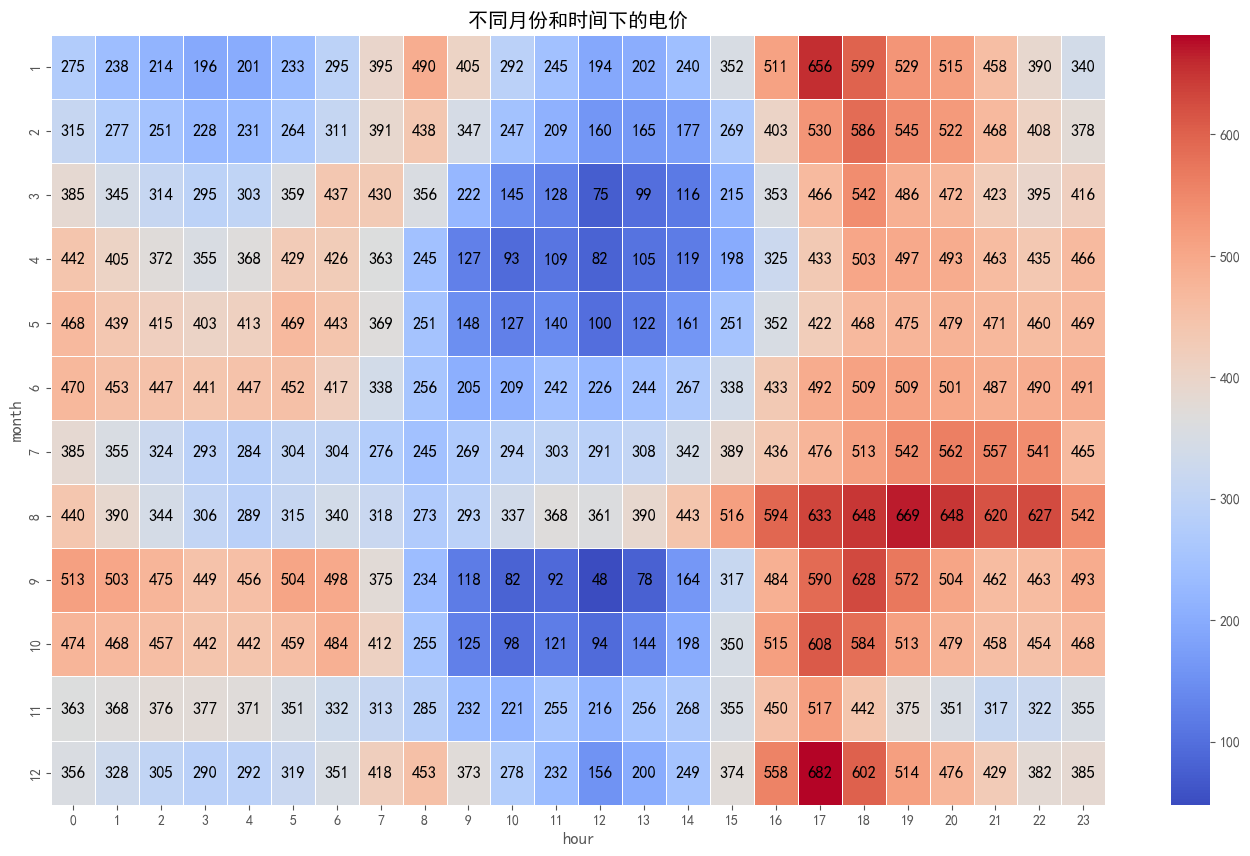

In [14]:
plt.figure(figsize=(17, 10))

# 绘制颜色图，显示不同月份和时间下的电价
sns.heatmap(
    p,                            # 透视表
    cmap="coolwarm",              # 使用 "coolwarm" 调色板，显示热图的颜色
    linewidths=0.5,               # 设置单元格之间的分隔线宽度为 0.5
    annot=True,                   # 启用单元格值的注释
    fmt=".0f",                    # 注释的格式为整数，即小数点后0位
    annot_kws={"size": 12,        # 注释文本的大小设置为 12
               "weight": "bold",  # 注释文本的字体加粗
               "color": "black"}  # 注释文本的颜色为黑色
)

plt.title("不同月份和时间下的电价")

从图中我们可以发现：
- 从1月到5月，电价的峰谷差距逐渐扩大，电价有下降趋势，但下午和傍晚时段的电价较高。
- 6-8月电价开始回升，8月达到年度最大值，尤其是晚间时段。
- 9-12月电价缓慢下降，11月和12月某些时段的电价略有回升。

由此我们可以结合地理知识做出猜测：
- 从冬至到夏至，日出时间不断提早，光伏发电更早抢占火电市场空间，导致火电更早在早高峰期间跌价。同时1-5月是大风期，风电也进一步驱使火电降价。
- 6-8月为小风期，风电减弱。同时雨带迁移到北方，光伏受天气影响发电量大幅减少，火电迎来高价区（尤其是8月降水最多，火电价格最高）
- 9-12月为大风期，风电加强。日出开始推迟，火电在低谷期的价格逐渐回升。

即：新能源发电是与火电互斥的

## 1.6 price 极端值分析

### 1.6.1 负电价

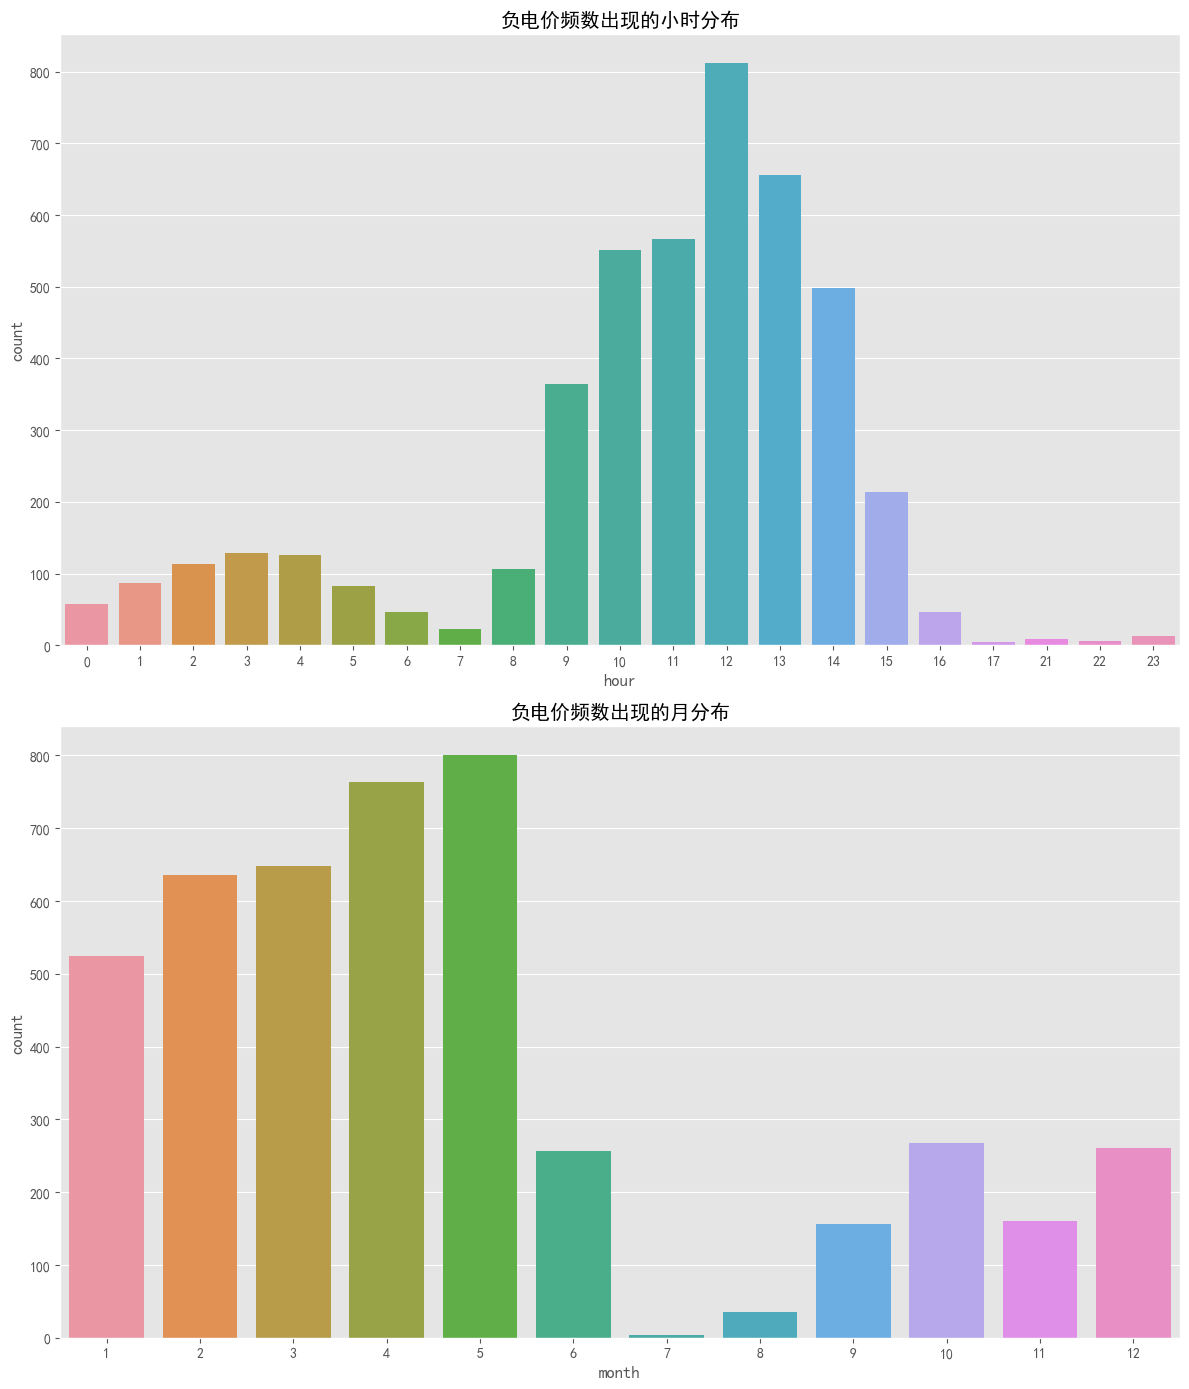

In [15]:
# 画出负电价的分布
minus_mask = electricity_price["price"] < 0

fig, axes = plt.subplots(2, 1, figsize=(12, 14))
ax1 = sns.countplot(electricity_price[minus_mask], x="hour", ax=axes[0])
ax1.set_title("负电价频数出现的小时分布")

ax2 = sns.countplot(electricity_price[minus_mask], x="month", ax=axes[1])
ax2.set_title("负电价频数出现的月分布")

# 调整布局
plt.tight_layout()
plt.show()

由上图可知，低谷期的负电价较为明显，我们猜测可能是受市场竞争导致电价中标失败，只能亏本售出。

进一步分析：

In [16]:
result = (
    electricity_price[minus_mask]         # 选择满足 minus_mask 条件的数据
    .groupby(["month", "day"])["price"]   # 按月份和日期分组，计算每个组合的记录数量
    .size()                               # 计算每个分组的大小（即每个分组的记录数）
    .reset_index(name="负电价频数")       # 重置索引，并将分组大小列重命名为 "负电价频数"
    .sort_values("负电价频数",              # 按 "负电价频数" 列
                 ascending=False)         # 降序排序
    .head(15)                             # 取前15个分组
)

result

,month,day,负电价频数
94,5,2,88
20,2,1,76
93,5,1,68
72,4,5,68
98,5,6,68
76,4,9,64
77,4,10,60
19,1,31,57
41,2,26,56
171,11,29,56


由此我们可以发现：
- 5月2日有88条记录，是记录数最多的组合。
- 2月1日有76条记录，记录数次多。
- 5月1日、4月5日、5月6日各有68条记录，并列第三多。

最典型的一次集中的负电价发生在2022年的五一假期中，连续出现了7次的负电价。如下图所示。

猜测是因为火电厂发电需要人为监控（例如开关机，设置出力，而风电和光伏放着自己发电就好），假期期间大多数员工放假，从而导致火力发电量下降，出现负电价。

Text(0.5, 1.0, '一段比较典型的负电价趋势：2022年5月1日 - 2022年5月9日')

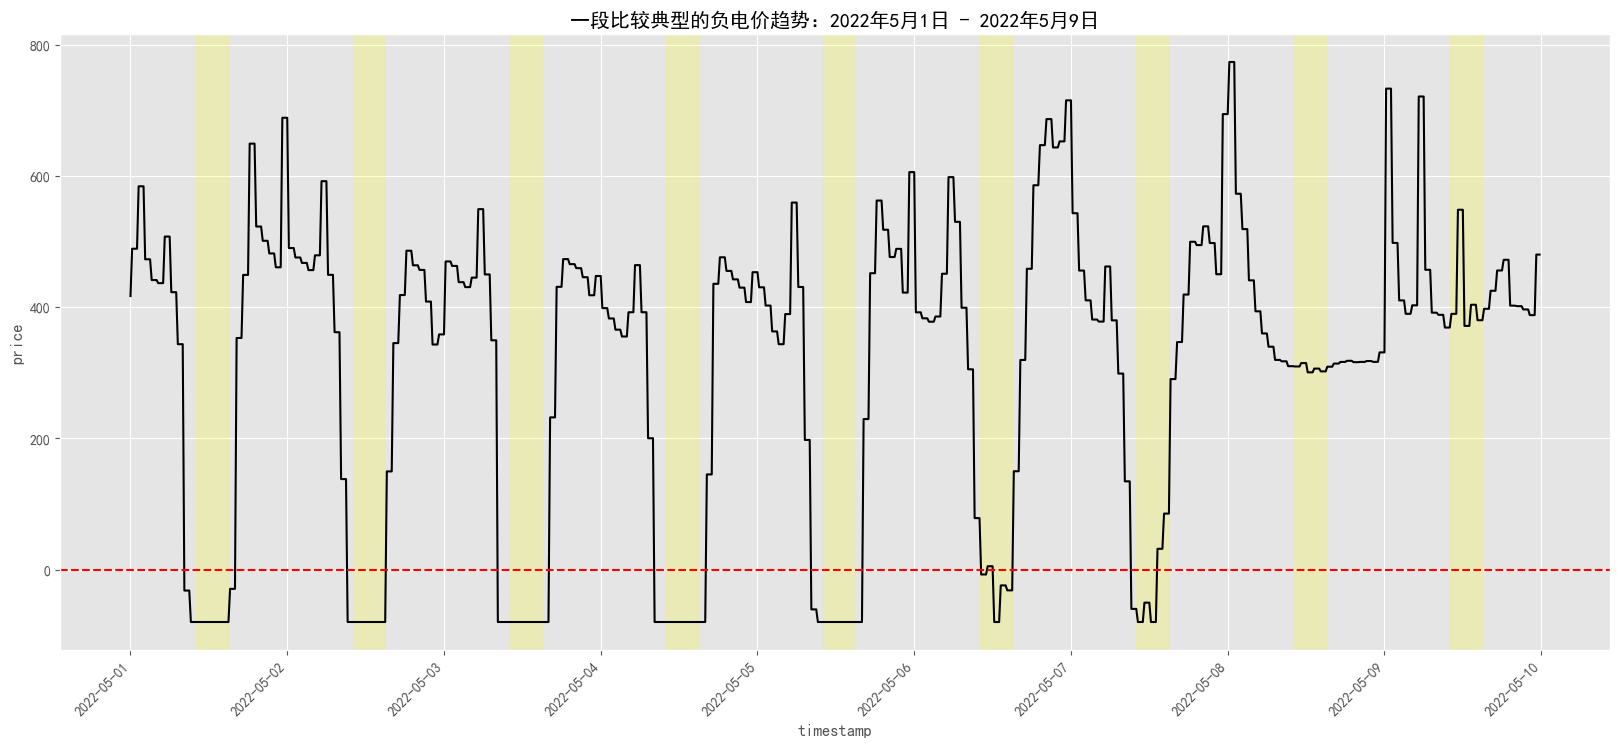

In [17]:
# 负电价典例
plt.figure(figsize=(20, 8))

# 绘制从2022年5月1日到2022年5月9日的电价数据的折线图
ax = sns.lineplot(
    electricity_price.loc["2022-05-01":"2022-05-09"]["price"],
    color="black"
)

# 在每一天的 10:00 到 15:00 之间添加黄色半透明的高亮区域
for i in range(1, 10):
    ax.axvspan(
        f"2022-05-0{i} 10:00:00",  # 高亮区域的开始时间
        f"2022-05-0{i} 15:00:00",  # 高亮区域的结束时间
        color='yellow',            # 高亮区域的颜色为黄色
        alpha=0.2                  # 高亮区域的透明度设置为 0.2（0 完全透明，1 完全不透明）
    )

# 添加一条红色的虚线，y 值为 0，用于显示负电价的参考线
plt.axhline(
    y=0,                      # y 轴的值为 0
    color="red",              # 虚线的颜色为红色
    linestyle="--"            # 虚线的线型为虚线
)

# 设置 x 轴刻度标签的旋转角度为 45 度，并且水平对齐方式为右对齐
plt.setp(
    ax.get_xticklabels(),     # 获取 x 轴刻度标签
    rotation=45,              # 设置标签的旋转角度为 45 度
    ha='right'                # 设置标签的水平对齐方式为右对齐
)

plt.title("一段比较典型的负电价趋势：2022年5月1日 - 2022年5月9日")

受此启发，我们还可以进一步探究假期对电价的影响，例如2022年的大年三十是1月31日，由于调休，1月28日-1月30日上班，1月31日-2月6日放假。

如下图，果然在春节假期中也出现了大量的负电价。

这说明节假日是判断负电价的重要特征

Text(0.5, 1.0, '假期对负电价的影响 2022年1月28日 - 2022年2月6日')

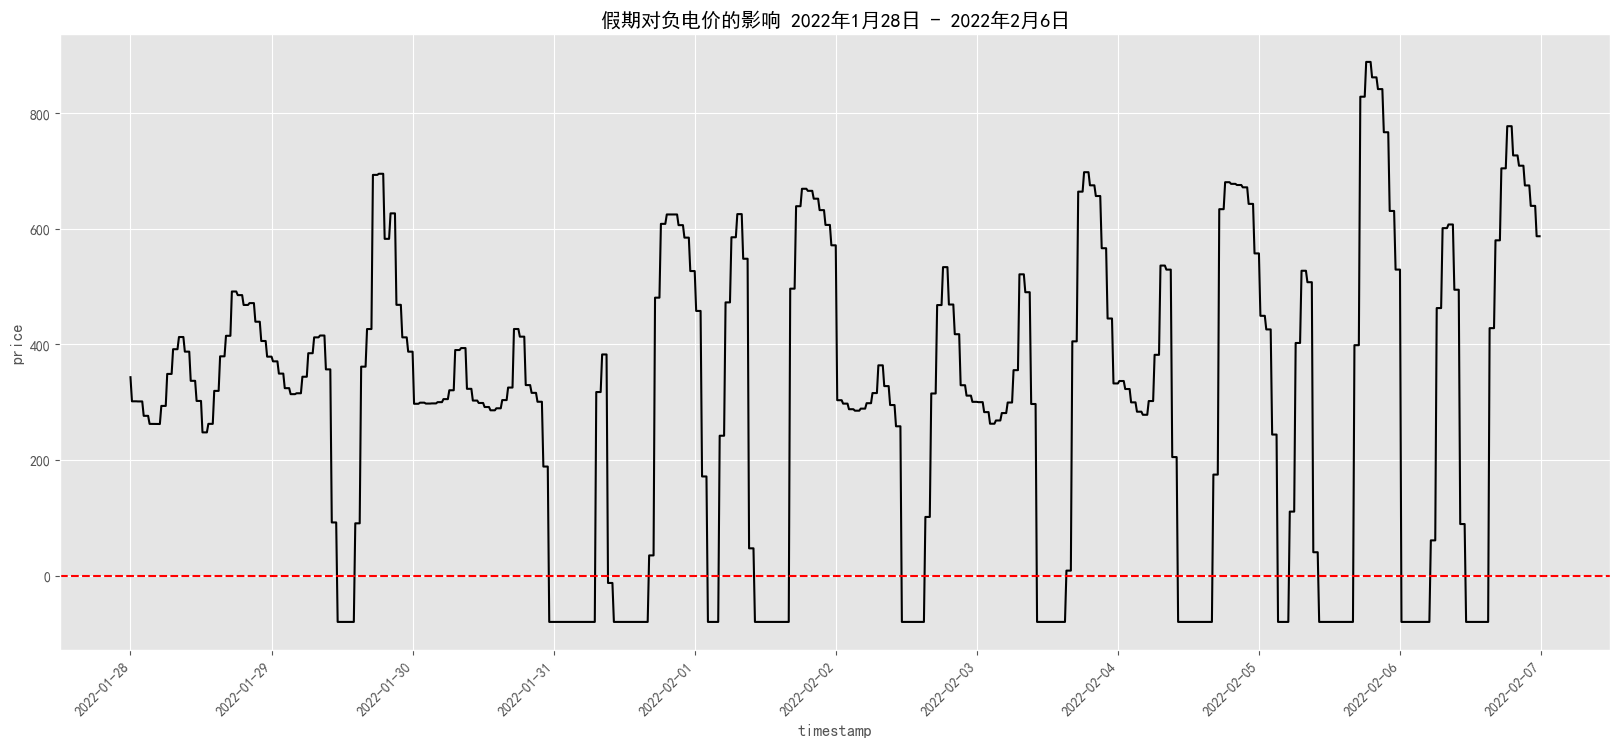

In [20]:
plt.figure(figsize=(20, 8))
ax = sns.lineplot(electricity_price.loc["2022-01-28":"2022-02-06"]["price"], color="black")
plt.axhline(y=0, color="red", linestyle="--")
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.title("假期对负电价的影响 2022年1月28日 - 2022年2月6日")

我们再来看看2023年的情况：

Text(0.5, 1.0, '假期对负电价的影响 2023年1月21日 - 2023年2月6日')

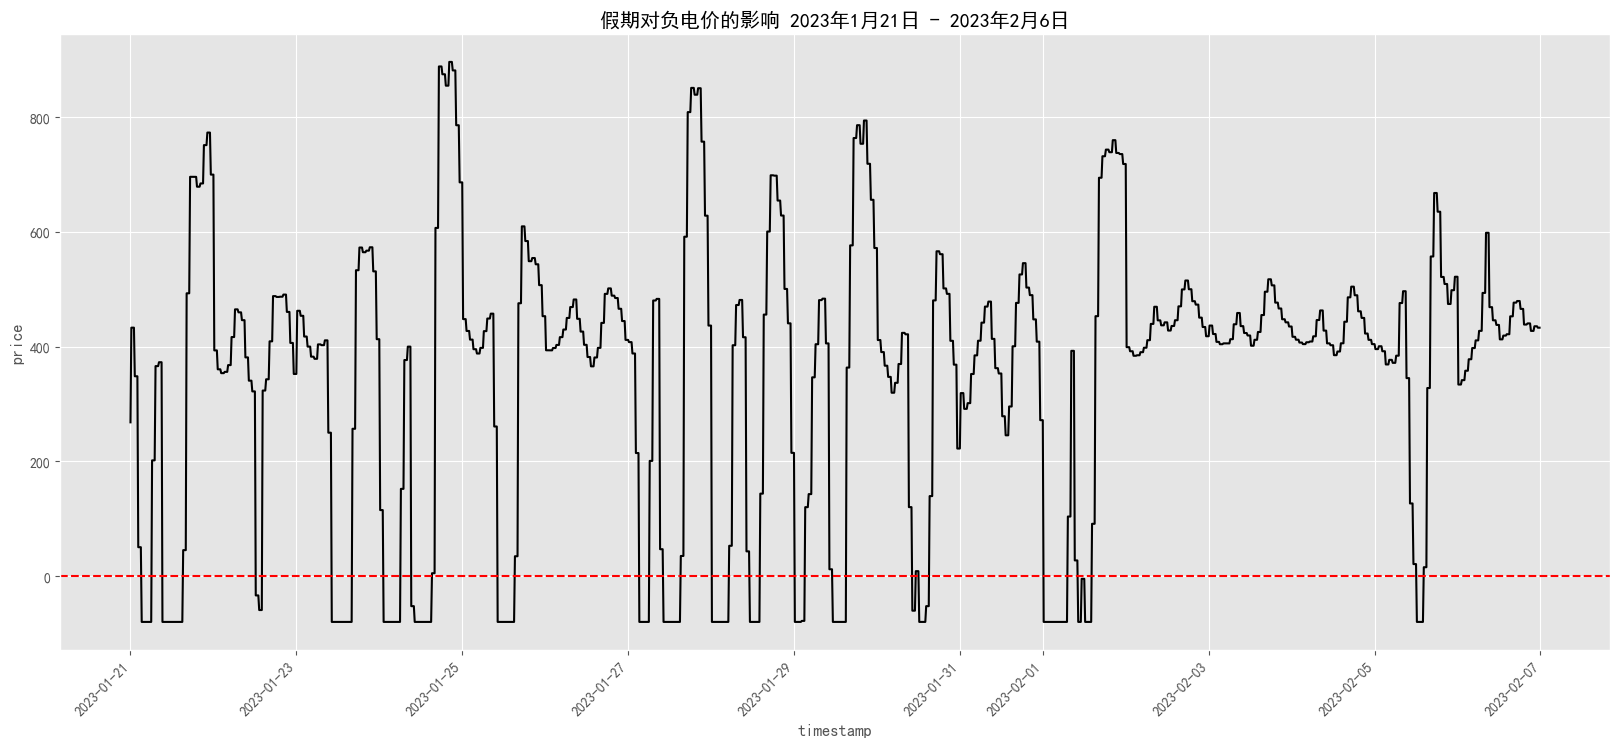

In [21]:
plt.figure(figsize=(20, 8))
ax = sns.lineplot(electricity_price.loc["2023-01-21":"2023-02-06"]["price"], color="black")
plt.axhline(y=0, color="red", linestyle="--")
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.title("假期对负电价的影响 2023年1月21日 - 2023年2月6日")

我们画出了2023年春节放假期间，1月21日-1月27日中的电价波动，并对比2023年的1月28日-2月6日电价情况，更加证明了假期特征的重要性。

### 1.6.2  高电价

分析方法和低电价类似

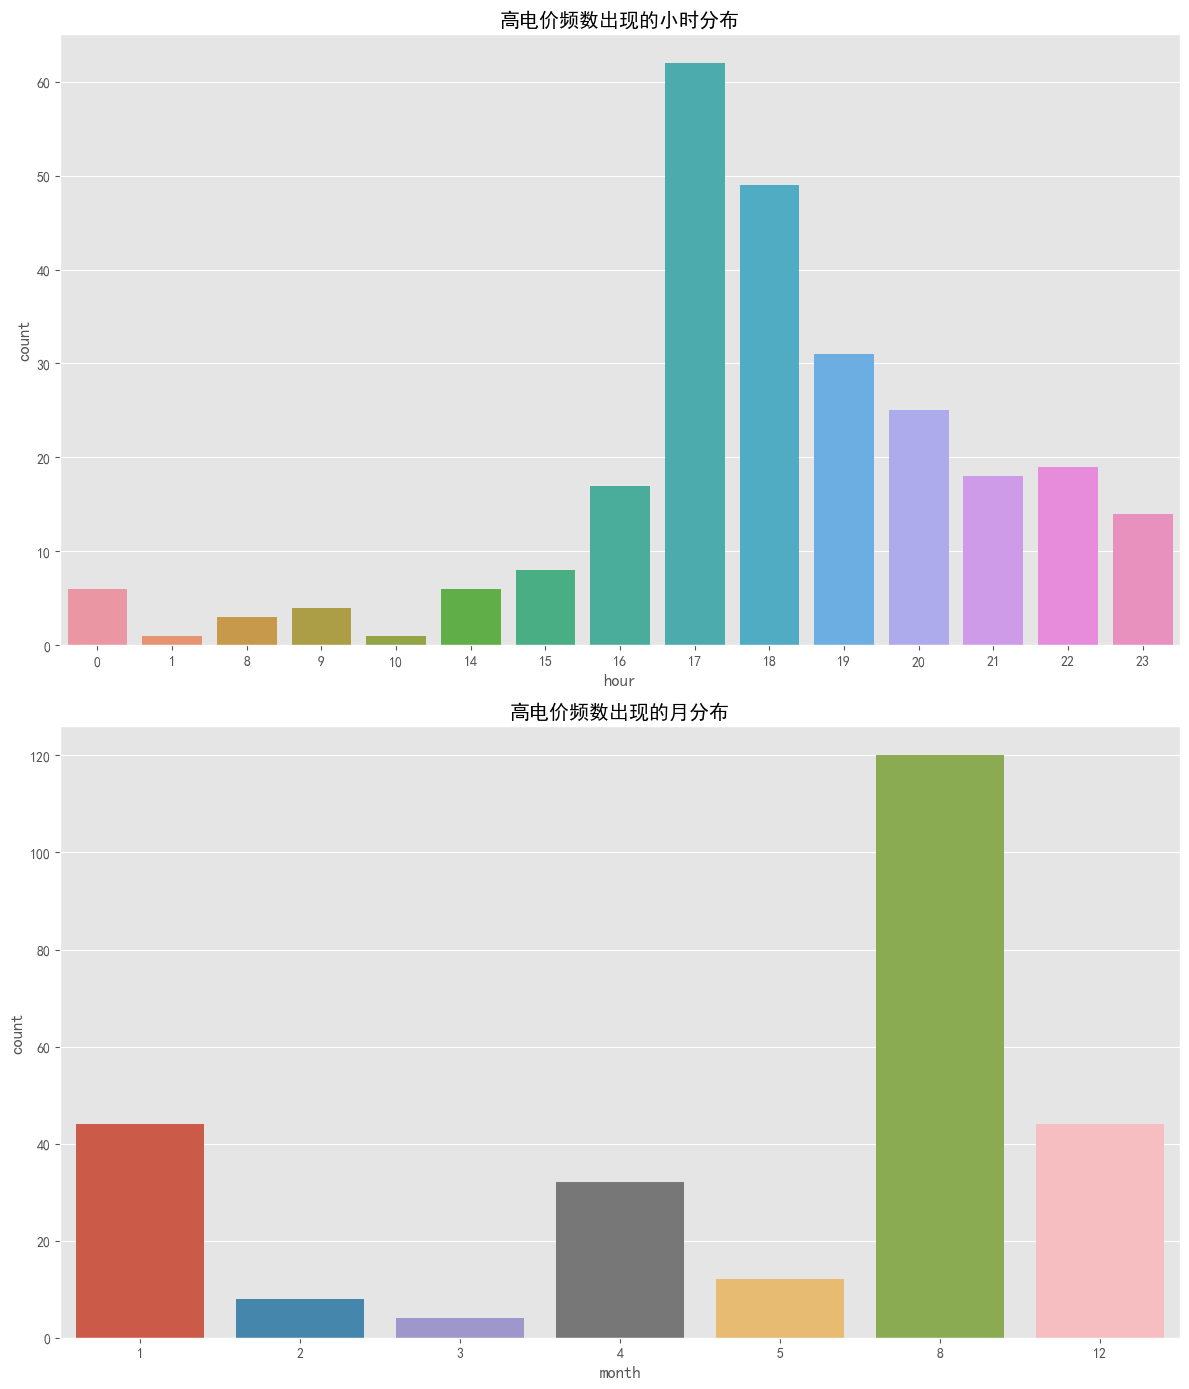

In [22]:
upper_threshold = (
    electricity_price["price"].mean() +       # 电价的均值
    3 * electricity_price["price"].std()      # 加上 3 倍的电价标准差，作为高电价的标准
)

# 画出高电价的分布
high_mask = (electricity_price["price"] > upper_threshold)

fig, axes = plt.subplots(2, 1, figsize=(12, 14))
ax1 = sns.countplot(electricity_price[high_mask], x="hour", ax=axes[0])
ax1.set_title("高电价频数出现的小时分布")

ax2 = sns.countplot(electricity_price[high_mask], x="month", ax=axes[1])
ax2.set_title("高电价频数出现的月分布")

# 调整布局
plt.tight_layout()
plt.show()

和负电价相反，高电价主要集中在日落后，此时光伏发电下降，火电有较大的竞价空间。

频数分析：

In [23]:
result = (
    electricity_price[high_mask]         
    .groupby(["month", "day"])["price"]  
    .size()                               
    .reset_index(name="高电价频数")       
    .sort_values("高电价频数",             
                 ascending=False)        
    .head(15)                            
)

result

,month,day,高电价频数
25,8,15,36
22,8,5,36
20,8,3,20
21,8,4,20
17,4,29,16
29,12,29,16
27,12,27,12
18,5,6,11
10,2,10,8
5,1,10,8


再来分析一下一些明显的高价时间段：

Text(0.5, 1.0, '2022年8月1日 - 2022年8月8日 总需求')

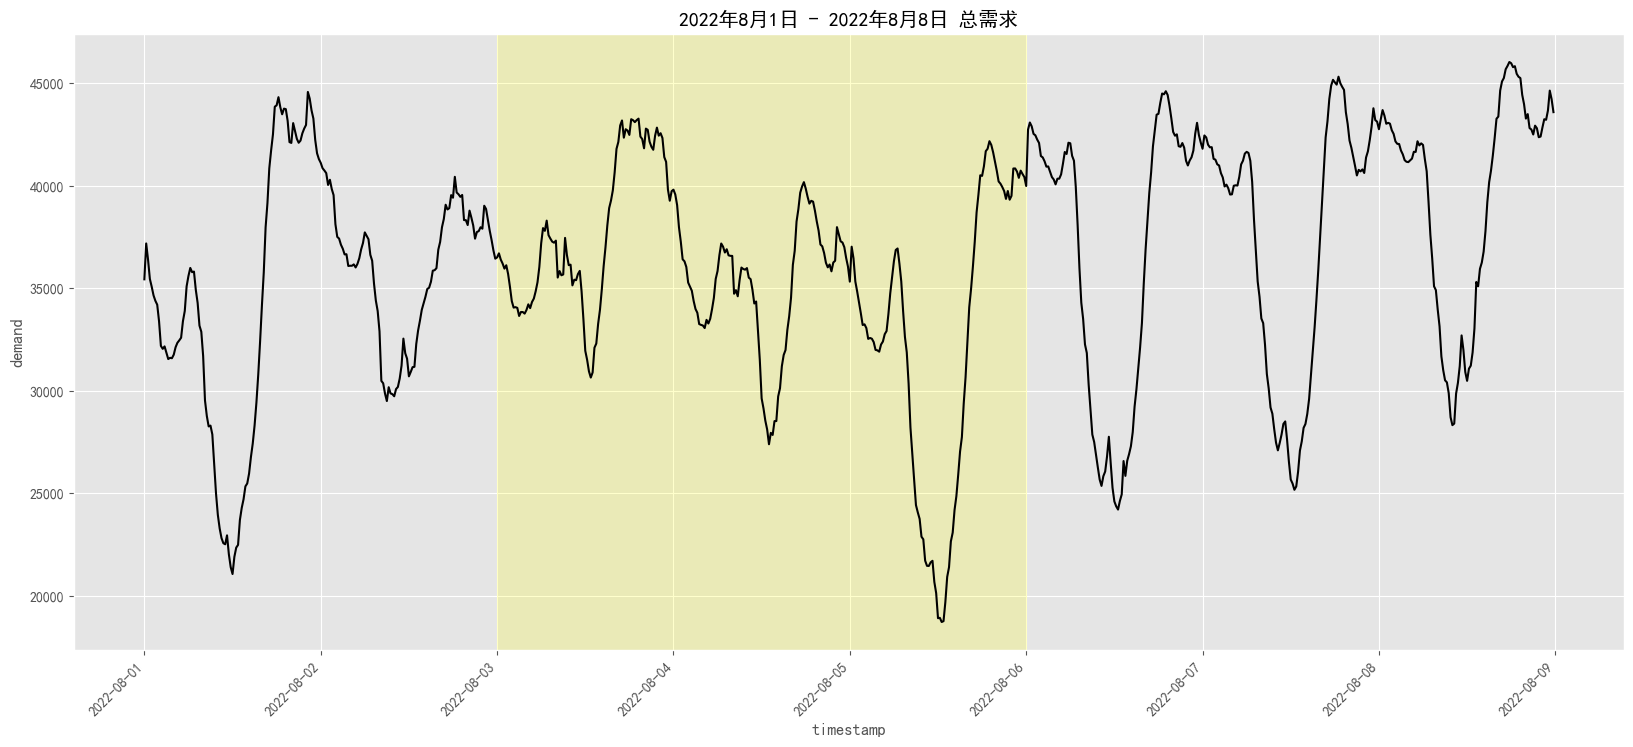

In [24]:
plt.figure(figsize=(20, 8))
ax = sns.lineplot(electricity_price.loc["2022-08-01":"2022-08-08"]["demand"], color="black")
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.axvspan("2022-08-03", "2022-08-06", color="yellow", alpha=0.2)
plt.title("2022年8月1日 - 2022年8月8日 总需求")

Text(0.5, 1.0, '典型高电价时间段 2022年8月1日 - 2022年8月8日 中的3-6日')

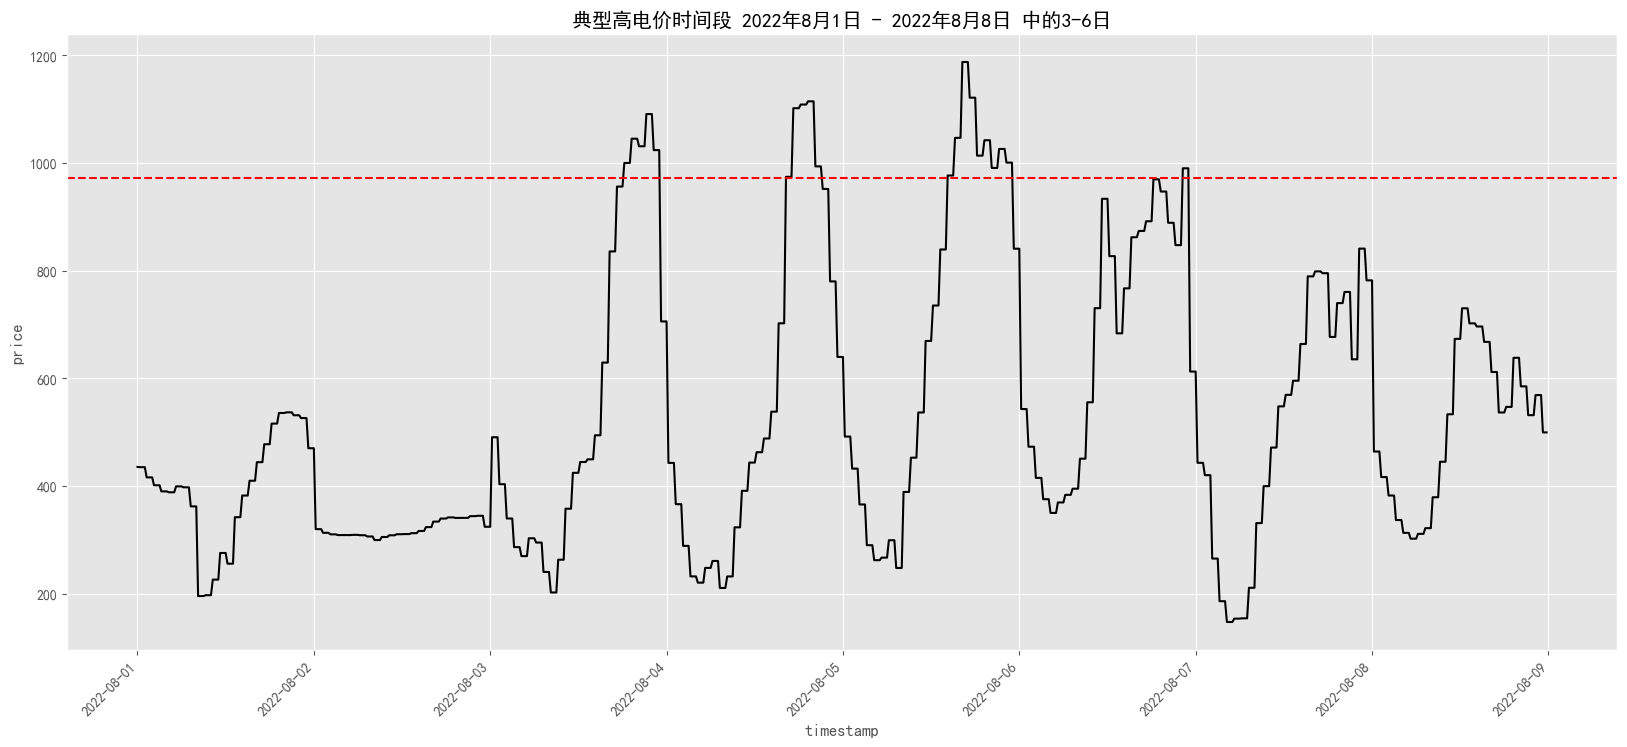

In [25]:
plt.figure(figsize=(20, 8))
ax = sns.lineplot(electricity_price.loc["2022-08-01":"2022-08-08"]["price"], color="black")
plt.axhline(y=upper_threshold, color="red", linestyle="--")
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.title("典型高电价时间段 2022年8月1日 - 2022年8月8日 中的3-6日")

通过对比明显高价的2022年8月3日-8月6日之间的数据，可以发现其在总需求上并不突出，甚至比后续日期中总需求更高的时间段价格还高，表明其受到了外部因素的影响

所以，利用外部数据也是上分的重要点

## 1.7 双变量分析

本题中特征均为连续型变量，因此我们可以采用画散点图，计算相关系数的方法来观察两个变量的关系。这步类似金融计量学中的画图法分析自相关性。

In [26]:
# 相关系数矩阵
electricity_price[["demand","price"]].corr()

,demand,price
demand,1.000000,0.343577
price,0.343577,1.000000


<Axes: xlabel='demand', ylabel='price'>

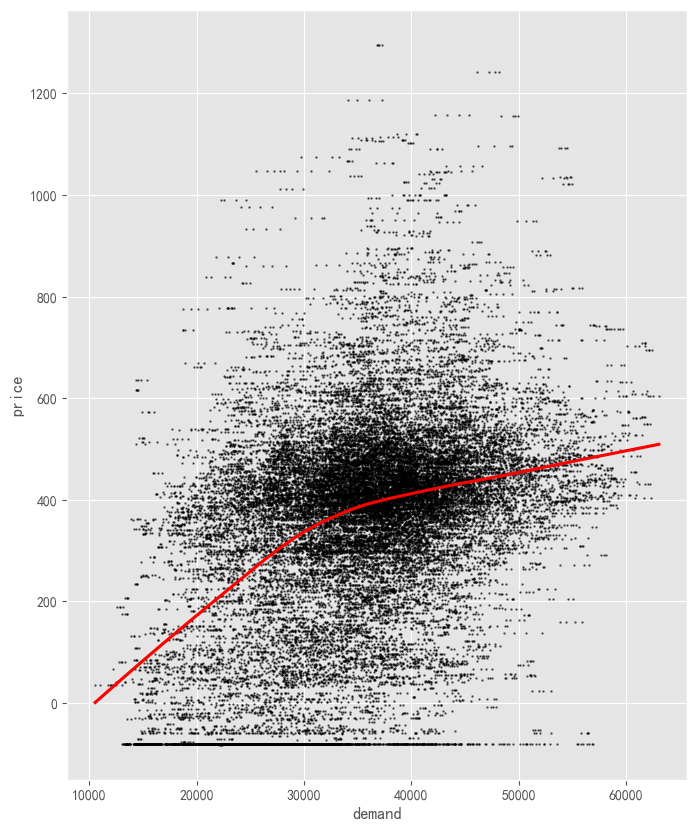

In [27]:
# 相关性散点图
plt.figure(figsize=(8, 10))

# 绘制回归图（散点图及拟合线）
sns.regplot(
    data=electricity_price.loc["2022"],  # 选择2022年的数据
    x="demand",                         # x 轴的变量为 "demand"
    y="price",                          # y 轴的变量为 "price"
    scatter_kws={                       # 设置散点图的样式
        "s": 0.5,                      # 散点的大小设置为 0.5
        "alpha": 0.6,                  # 散点的透明度设置为 0.6
        "color": "black"               # 散点的颜色设置为黑色
    },
    color="red",                        # 拟合线的颜色设置为红色
    lowess=True                          # 启用局部加权回归（Lowess）以拟合数据
)

# 跑了1分半。。

可以发现，demand和price的相关系数为0.34，可以看出二者有较高的线性相关性。并且我们还能发现，在高负荷下，价格变动趋缓。

## 1.8 总结

经过EDA分析，我们有如下结论：
- 气象状况（or季节）对出清价格有较大影响
- 节假日对出清价格有较大影响，易于出现负值（春节、劳动节）
- 总负荷与出清价格线性关系很高（ρ=0.34），但总体呈现分段线性的特征
- 不同月份/小时下的出清价格受市场竞争影响较大
- 碳中和不断发展，预计火电价格有总体下降的趋势

# 2 Baseline 精读

详见修改后的[Task 1 Baseline](../Task1/my_baseline.ipynb)

# 3 ABM 实践进阶